# Test model V1

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump,load
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from tensorflow.keras.models import load_model


In [2]:
df_test = pd.read_csv(r"../data/simulated_test.csv")

In [3]:
def smart_fill_temp(series):
    series = series.copy()
    for idx in series[series.isna()].index:
        # Look forward to next 2 valid values
        next_vals = series[idx+1:idx+10].dropna().values[:2]
        if len(next_vals) > 0:
            avg_val = round(np.mean(next_vals))
            series.loc[idx] = avg_val
    return series

df_test['TEMP_30MIN_AGO'] = smart_fill_temp(df_test['TEMP_30MIN_AGO'].astype(float))

df_test['IRR_15MIN_AGO']= df_test['IRR_15MIN_AGO'].fillna(0.0)

In [4]:
df_test.columns

Index(['DATE_TIME', 'AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_POWER', 'HOUR',
       'MINUTE', 'HOUR_SIN', 'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 'DC_PER_IRR',
       'IRR_15MIN_AGO', 'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND'],
      dtype='object')

## MLP Baseline

In [5]:
df_test_mlp = df_test.copy()

In [6]:
df_test_mlp= df_test.drop(columns=['DATE_TIME','HOUR','MINUTE'])

In [7]:
features = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR',
       'HOUR_SIN', 'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 
       'IRR_15MIN_AGO', 'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND']
target = ['DC_POWER']
scale = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR','IRR_15MIN_AGO', 'TEMP_30MIN_AGO']

In [8]:
model = load_model(r'../model/MLP_base_model.keras')
scaler_X = load(r'../model/mlp_x_scaler.joblib')
scaler_y = load(r'../model/mlp_y_scaler.joblib')

In [9]:
X_to_scale = df_test_mlp[scale]
X_rest = df_test_mlp[[col for col in features if col not in scale]]

X_scaled = pd.DataFrame(scaler_X.fit_transform(X_to_scale), columns=scale, index=df_test_mlp.index)

X = pd.concat([X_scaled, X_rest], axis=1)[features]

In [10]:
y = df_test_mlp[target]

y_scaled = pd.DataFrame(scaler_y.fit_transform(y),columns=target,index=df_test_mlp.index)
y = y_scaled

In [11]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [12]:
y_pred_scaled = np.clip(model.predict(X_val), 0, None)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step 


In [13]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_inv = scaler_y.inverse_transform(y_val)

In [14]:
print(f"MAE: {mean_absolute_error(y_val_inv, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_inv, y_pred)):.4f}")
print(f"R²: {r2_score(y_val_inv, y_pred):.4f}")

MAE: 0.4065
RMSE: 0.6884
R²: 0.9819


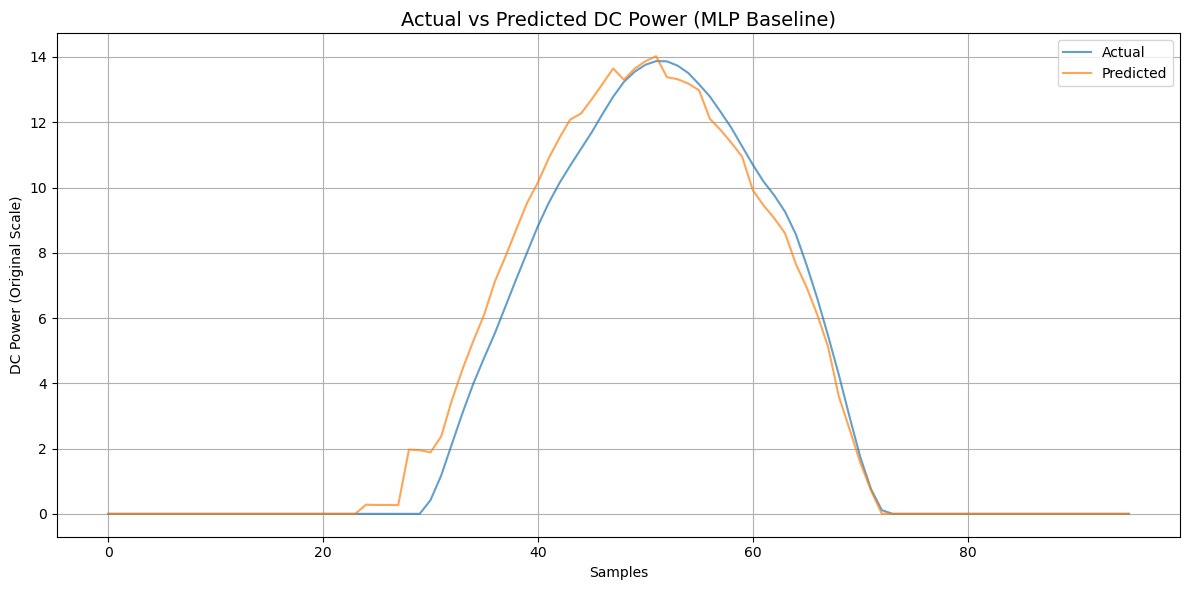

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted DC Power (MLP Baseline)', fontsize=14)
plt.xlabel('Samples')
plt.ylabel('DC Power (Original Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

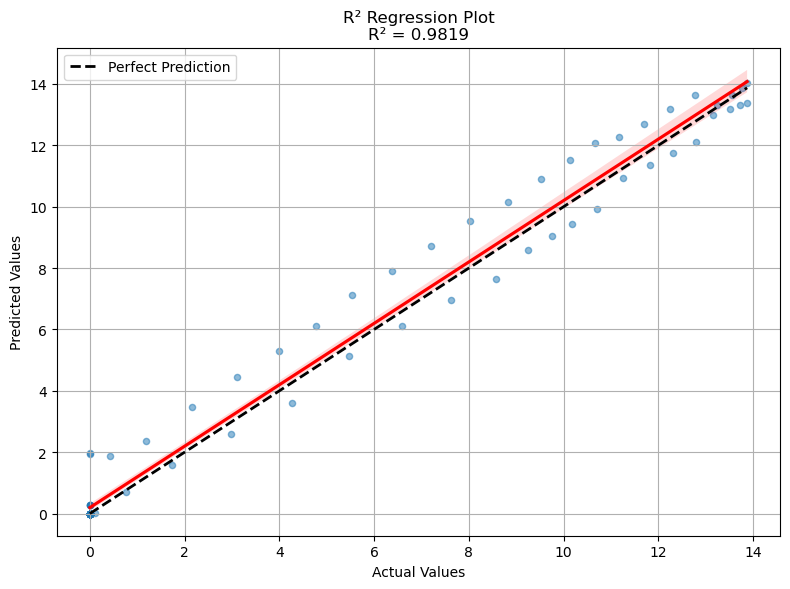

In [16]:
r2 = r2_score(y_val_inv, y_pred)

plt.figure(figsize=(8, 6))
sns.regplot(x=y_val_inv, y=y_pred, scatter_kws={"alpha":0.5, "s": 20}, line_kws={"color":"red"})
plt.plot([y_val_inv.min(), y_val_inv.max()], [y_val_inv.min(), y_val_inv.max()], 'k--', lw=2, label='Perfect Prediction')

plt.title(f'R² Regression Plot\nR² = {r2:.4f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Step 1: Ensure y_val has a datetime index
# If your timestamps are in a column (say 'timestamp'), use this:
date_time = df_test.loc[y_val.index,'DATE_TIME']  # or X_val['timestamp'] if you’ve got it as a column

# Step 2: Construct a DataFrame to plot
df_forecast = pd.DataFrame({
    "DATE_TIME": date_time,
    "Actual": y_val_inv.flatten(),
    "Predicted": y_pred.flatten()
})

# Convert to datetime if needed
df_forecast["DATE_TIME"] = pd.to_datetime(df_forecast["DATE_TIME"])

# Filter between 10:00 and 14:00
mask = (df_forecast["DATE_TIME"].dt.time >= pd.to_datetime("07:00").time()) & \
       (df_forecast["DATE_TIME"].dt.time <= pd.to_datetime("14:00").time())

df_8hr = df_forecast[mask]
df_hourly = df_forecast.iloc[::4]  # Every 4th row = 1 hour



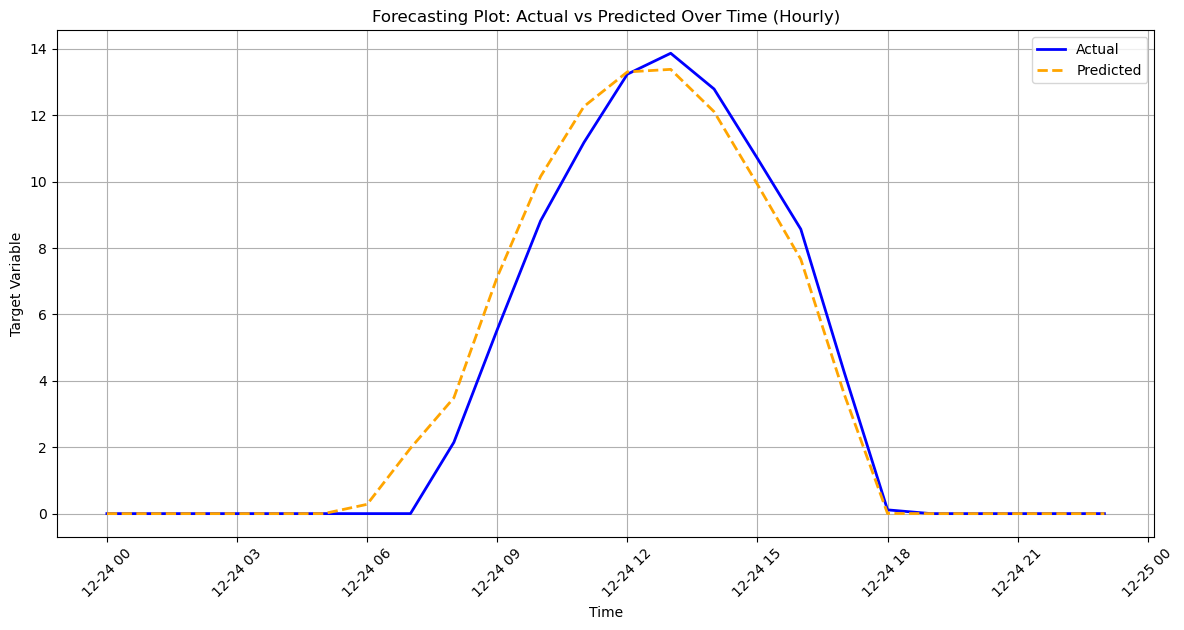

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df_hourly["DATE_TIME"], df_hourly["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_hourly["DATE_TIME"], df_hourly["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (Hourly)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


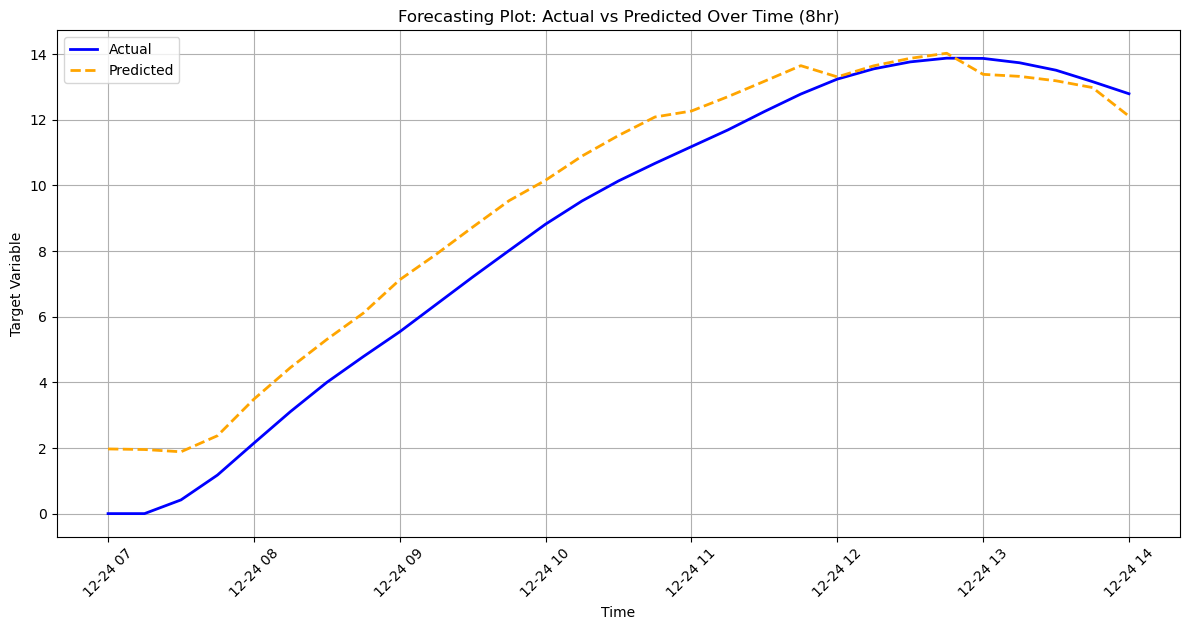

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df_8hr["DATE_TIME"], df_8hr["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_8hr["DATE_TIME"], df_8hr["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (8hr)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [21]:
df_forecast.to_csv(r'../output/forecasted_mlp.csv')

## LSTM

In [22]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [23]:
df_test_lstm = df_test.copy()

In [24]:
features = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR',
       'HOUR_SIN', 'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 
       'IRR_15MIN_AGO', 'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND']
target = ['DC_POWER']
scale = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR','IRR_15MIN_AGO', 'TEMP_30MIN_AGO']

In [25]:
X_to_scale = df_test_lstm[scale]
X_rest = df_test_lstm[[col for col in features if col not in scale]]

scaler_x = load(r'../model/lstm_x_scaler.joblib')
X_scaled = pd.DataFrame(scaler_x.fit_transform(X_to_scale), columns=scale, index=df_test_lstm.index)

X = pd.concat([X_scaled, X_rest], axis=1)[features]

In [26]:
y = df_test_lstm[target]

scaler_y = load(r'../model/lstm_y_scaler.joblib')
y_scaled = pd.DataFrame(scaler_y.fit_transform(y),columns=target,index=df_test_lstm.index)
y = y_scaled

In [27]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [28]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))

In [29]:
model = load_model(r'../model/LSTM_model.keras')

In [30]:
y_pred_scaled = np.clip(model.predict(X_val), 0, None) 
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_inv = scaler_y.inverse_transform(y_val)

print(f"MAE: {mean_absolute_error(y_val_inv, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_inv, y_pred)):.4f}")
print(f"R²: {r2_score(y_val_inv, y_pred):.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
MAE: 0.2401
RMSE: 0.3480
R²: 0.9954


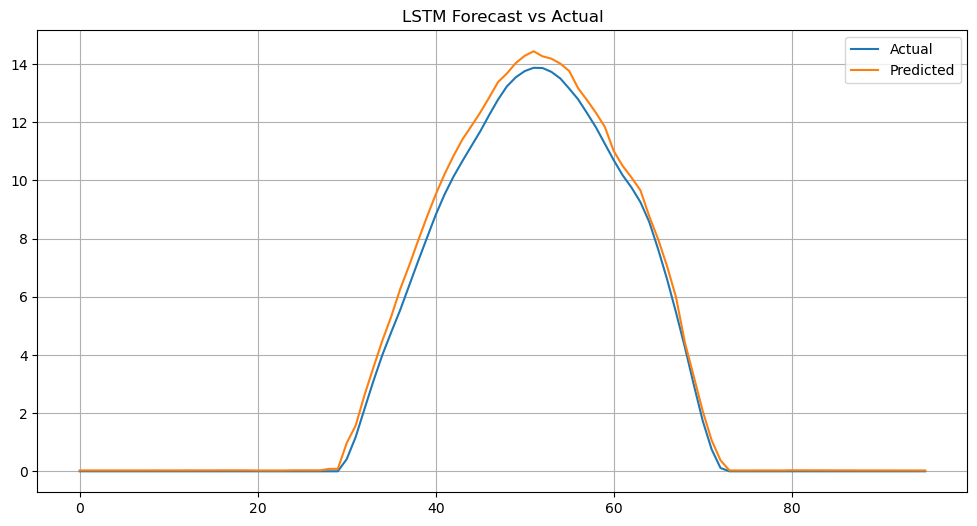

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_val_inv, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

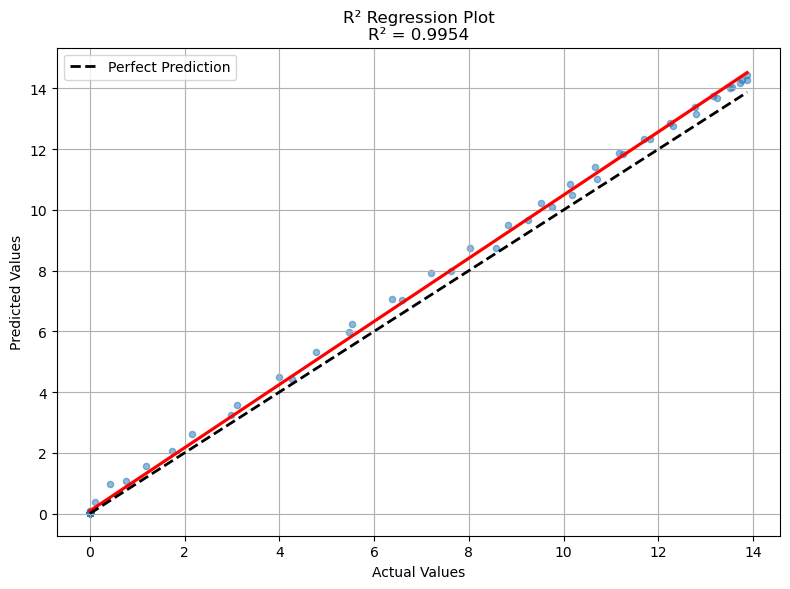

In [32]:
r2 = r2_score(y_val_inv, y_pred)

plt.figure(figsize=(8, 6))
sns.regplot(x=y_val_inv.flatten(), y=y_pred.flatten(), scatter_kws={"alpha":0.5, "s": 20}, line_kws={"color":"red"})
plt.plot([y_val_inv.min(), y_val_inv.max()], [y_val_inv.min(), y_val_inv.max()], 'k--', lw=2, label='Perfect Prediction')

plt.title(f'R² Regression Plot\nR² = {r2:.4f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Extract DATE_TIME column before converting to numpy
date_time = df_test["DATE_TIME"]

# Manual split
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]
dt_train, dt_val = date_time[:train_size], date_time[train_size:]

# Convert to NumPy arrays
y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))
  


df_forecast = pd.DataFrame({
    "DATE_TIME": dt_val.reset_index(drop=True),
    "Actual": y_val_inv.flatten(),
    "Predicted": y_pred.flatten()
})

df_forecast["DATE_TIME"] = pd.to_datetime(df_forecast["DATE_TIME"])  

mask = (df_forecast["DATE_TIME"].dt.time >= pd.to_datetime("07:00").time()) & \
       (df_forecast["DATE_TIME"].dt.time <= pd.to_datetime("14:00").time())

df_8hr = df_forecast[mask]
df_hourly = df_forecast.iloc[::4]  





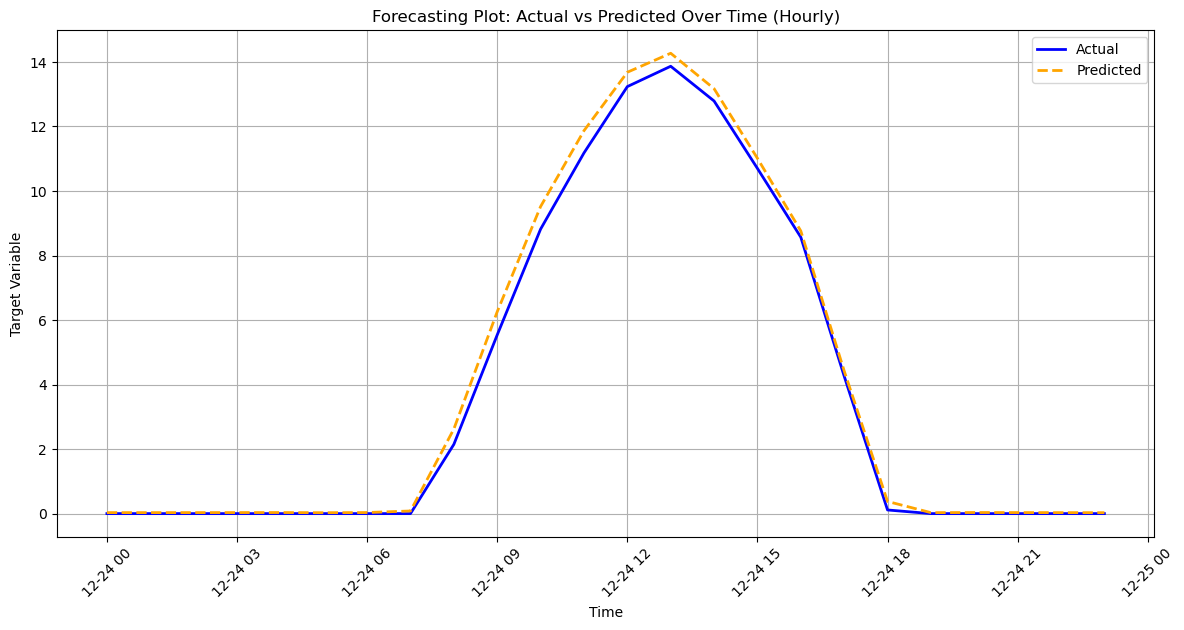

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(df_hourly["DATE_TIME"], df_hourly["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_hourly["DATE_TIME"], df_hourly["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (Hourly)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


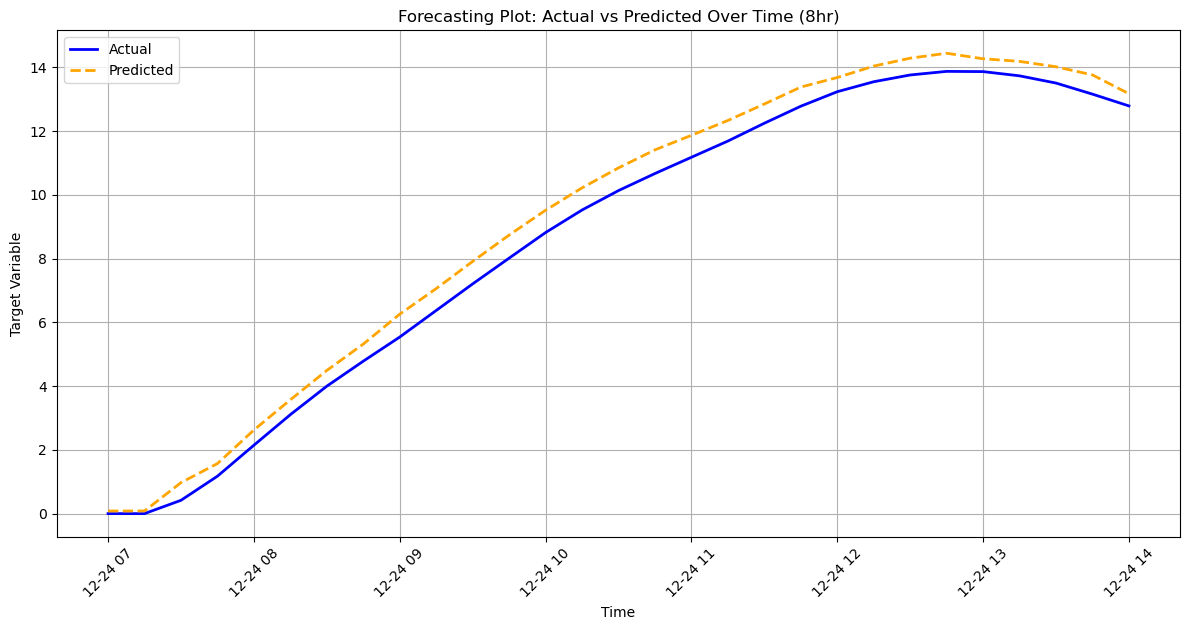

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(df_8hr["DATE_TIME"], df_8hr["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_8hr["DATE_TIME"], df_8hr["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (8hr)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [51]:
df_forecast.to_csv(r'../output/forecasted_lstm.csv',index=False)

## Bidirectional LSTM and CNN

In [37]:
df_test_bic = df_test.copy()

In [38]:
features = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR',
       'HOUR_SIN', 'HOUR_COS', 'IS_NIGHT', 'DAWN_DUSK', 
       'IRR_15MIN_AGO', 'TEMP_30MIN_AGO', 'DAY_OF_WEEK', 'IS_WEEKEND']
target = ['DC_POWER']
scale = ['AMBIENT_TEMPERATURE', 'IRRADIATION', 'DC_PER_IRR','IRR_15MIN_AGO', 'TEMP_30MIN_AGO']

In [39]:
X_to_scale = df_test_bic[scale]
X_rest = df_test_bic[[col for col in features if col not in scale]]

scaler_x = load(r'../model/bi_directional_and_1dCNN_X_scaler.joblib')
X_scaled = pd.DataFrame(scaler_x.fit_transform(X_to_scale), columns=scale, index=df_test_lstm.index)

X = pd.concat([X_scaled, X_rest], axis=1)[features]

In [40]:
y = df_test_bic[target]

scaler_y = load(r'../model/bi_directional_and_1dCNN_y_scaler.joblib')
y_scaled = pd.DataFrame(scaler_y.fit_transform(y),columns=target,index=df_test_bic.index)
y = y_scaled

In [41]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [42]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))

In [43]:
model = load_model(r'../model/bi_lstm_1dcnn_model.keras')

In [44]:
y_pred_scaled = np.clip(model.predict(X_val), 0, None) 
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_val_inv = scaler_y.inverse_transform(y_val)

print(f"MAE: {mean_absolute_error(y_val_inv, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_inv, y_pred)):.4f}")
print(f"R²: {r2_score(y_val_inv, y_pred):.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
MAE: 0.5279
RMSE: 0.8464
R²: 0.9726


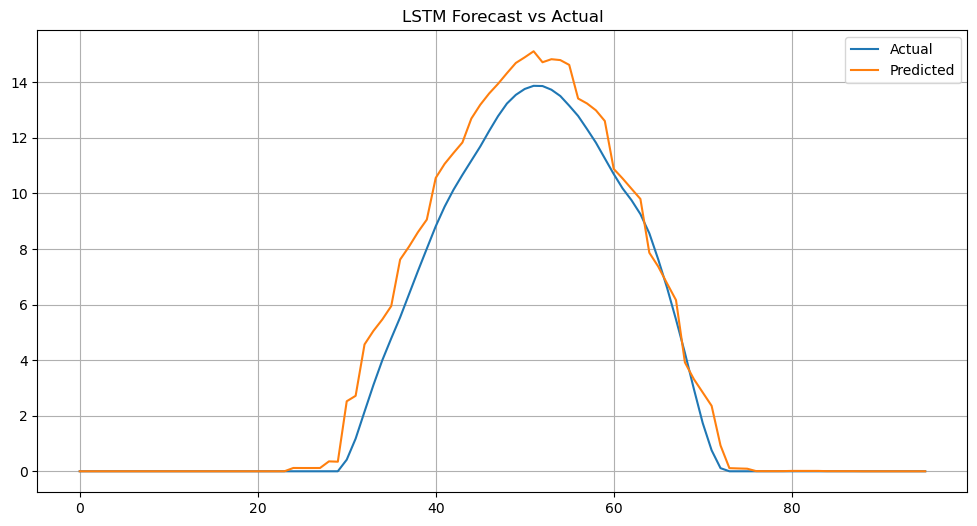

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_val_inv, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

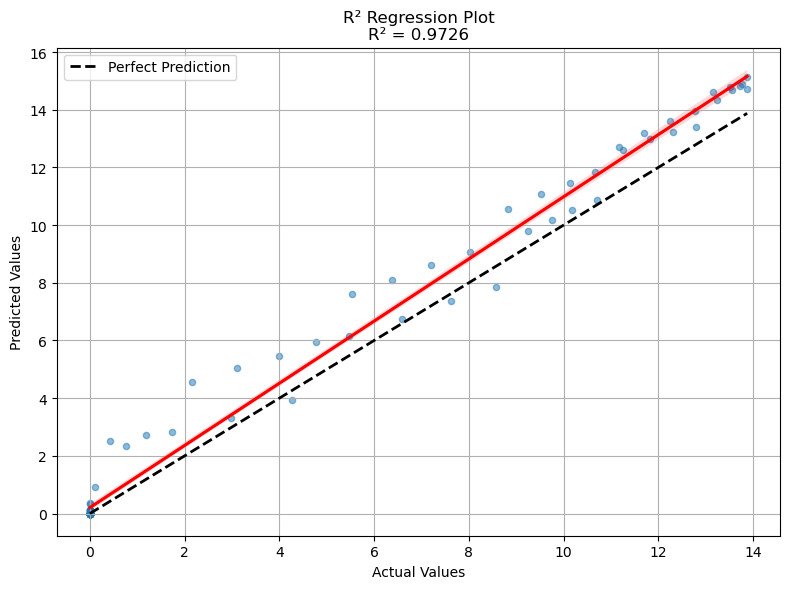

In [46]:
r2 = r2_score(y_val_inv, y_pred)

plt.figure(figsize=(8, 6))
sns.regplot(x=y_val_inv.flatten(), y=y_pred.flatten(), scatter_kws={"alpha":0.5, "s": 20}, line_kws={"color":"red"})
plt.plot([y_val_inv.min(), y_val_inv.max()], [y_val_inv.min(), y_val_inv.max()], 'k--', lw=2, label='Perfect Prediction')

plt.title(f'R² Regression Plot\nR² = {r2:.4f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Extract DATE_TIME column before converting to numpy
date_time = df_test["DATE_TIME"]

# Manual split
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]
dt_train, dt_val = date_time[:train_size], date_time[train_size:]

# Convert to NumPy arrays
y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))
  


df_forecast = pd.DataFrame({
    "DATE_TIME": dt_val.reset_index(drop=True),
    "Actual": y_val_inv.flatten(),
    "Predicted": y_pred.flatten()
})

df_forecast["DATE_TIME"] = pd.to_datetime(df_forecast["DATE_TIME"])  

mask = (df_forecast["DATE_TIME"].dt.time >= pd.to_datetime("07:00").time()) & \
       (df_forecast["DATE_TIME"].dt.time <= pd.to_datetime("14:00").time())

df_8hr = df_forecast[mask]
df_hourly = df_forecast.iloc[::4]  





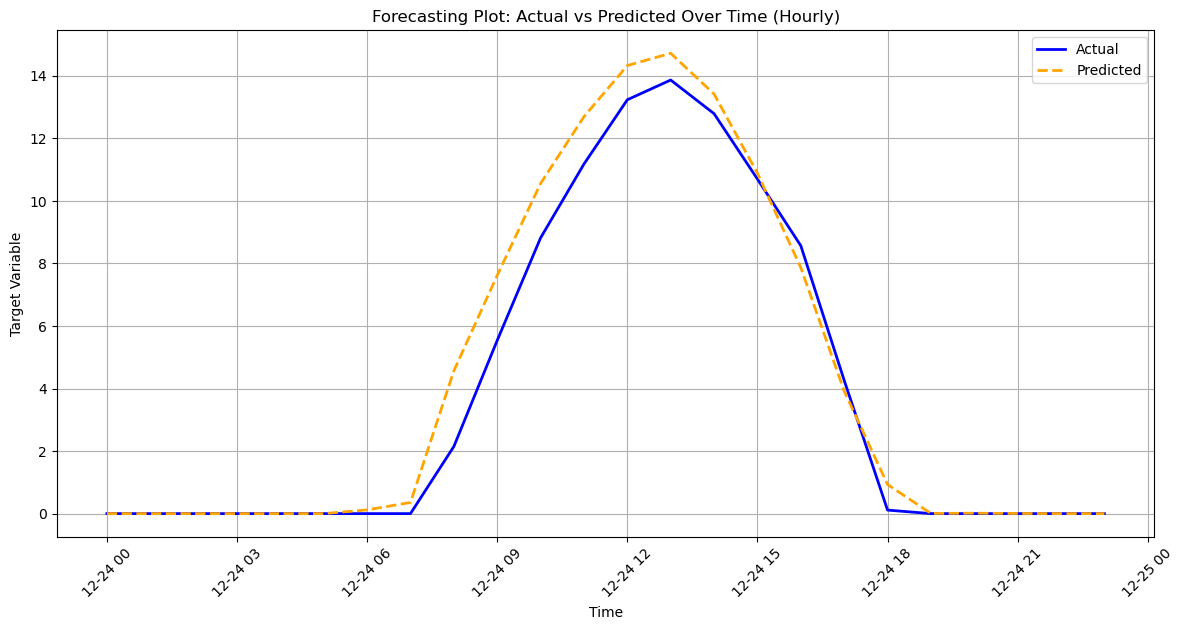

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(df_hourly["DATE_TIME"], df_hourly["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_hourly["DATE_TIME"], df_hourly["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (Hourly)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


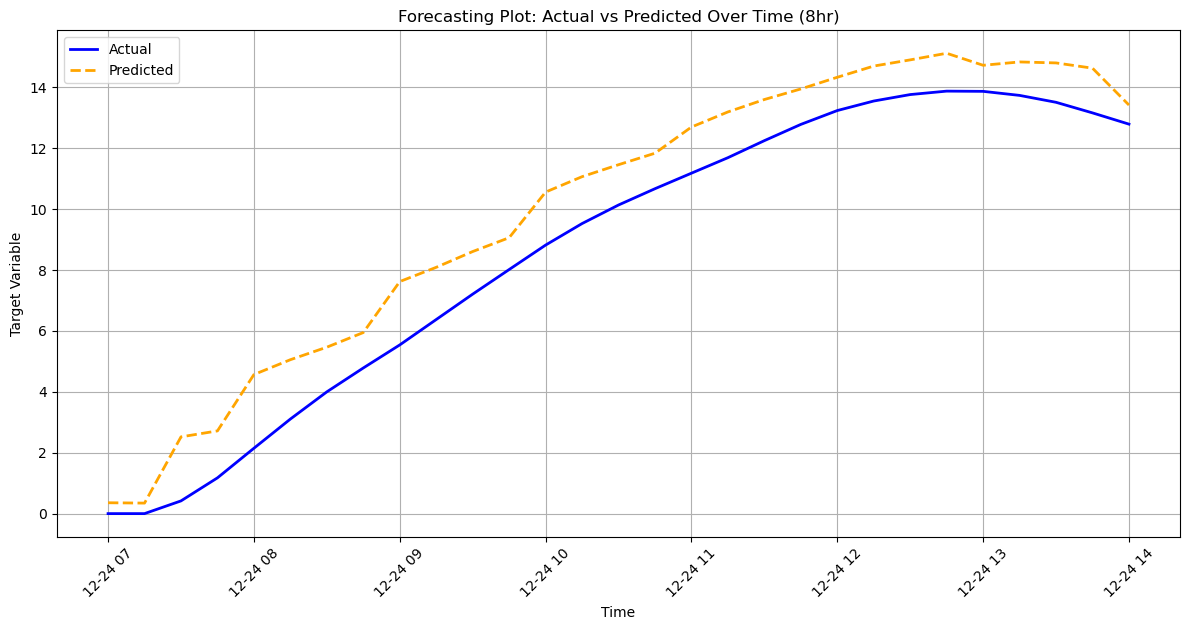

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(df_8hr["DATE_TIME"], df_8hr["Actual"], label="Actual", color="blue", linewidth=2)
plt.plot(df_8hr["DATE_TIME"], df_8hr["Predicted"], label="Predicted", color="orange", linestyle="--", linewidth=2)

plt.title("Forecasting Plot: Actual vs Predicted Over Time (8hr)")
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [50]:
df_forecast.to_csv(r'../output/forecasted_bi_lstm_and_cnn.csv')